<a href="https://colab.research.google.com/github/abubakrsiddq/ImageDehazing/blob/main/models/GCA-Net/gca_kitti.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import random
from PIL import Image
import time
import datetime

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mean_squared_error
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import *
from tensorflow.keras import backend as K
import math

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def load_image(img_path):
    img = tf.io.read_file(img_path)
    
    img = tf.io.decode_png(img, channels = 3)
    img = tf.image.resize(img, size = (352 , 1216), antialias = True)
    img = img / 255.0
    return img

In [ ]:
def dataset_preposses(orig_img_path='/content/drive/MyDrive/generated_dataset/trans',hazy_img_path='/content/drive/MyDrive/generated_dataset/hazy',percentage=0.1,validation_size=200,test_size=64,seed_val=200):
    train_img = []
    val_img = []
    random.seed=seed_val
    orig_img = glob.glob(orig_img_path + '/*.png')
    n = len(orig_img)
    random.shuffle(orig_img)
    red_keys=orig_img[:]                                 #redundant keys to avoid key error
    train_keys = orig_img[:int(0.9*n*percentage)]
    #print(0.9*n*percentage)
    #print(len(train_keys))
    val_keys = orig_img[-int(0.1*n*percentage):]
    #print(len(val_keys))
    split_dict = {}
    #i=0
    for key in red_keys:
      split_dict[key]='red'
      #i+=1
    #print(i)
    for key in train_keys:
      split_dict[key] = 'train'
    for key in val_keys:
      split_dict[key] = 'val'
      
    hazy_img = glob.glob(hazy_img_path + '/*.png')
    for img in hazy_img:
      
      img_name = img.split('/')[-1][:-4].split('_')[0]
      orig_path = orig_img_path + '/' + img_name+'.png'
      if (split_dict[orig_path] == 'train'):
        train_img.append([img, orig_path])
      if (split_dict[orig_path] == 'val'):
        val_img.append([img, orig_path])
      

    return train_img, val_img


def gen_dataset(ar):
  '''
  parameters
  list of paths
  return
  list with gt attached 
  '''
  orig_path='/content/drive/MyDrive/kitti/gt'
  haze_pth='/content/drive/MyDrive/kitti/hazy'
  lst=[]
  for i in ar:
    name=i.split('/')[-1].split('_')[0]
    pthlist=[i,orig_path+'/'+name+'.jpg']
    lst.append(pthlist)
  return lst

def data_path(orig_img_path = '/content/drive/MyDrive/kitti/gt', hazy_img_path = '/content/drive/MyDrive/kitti/hazy'):
  
  (a,b,c)=dataset_preposses(orig_path=orig_img_path,haze_path=hazy_img_path)
  a=gen_dataset(a)
  b=gen_dataset(b)
  return a,b

In [ ]:
def dataloader(train_data, val_data, batch_size):
    print(len(train_data))
    train_data_orig = tf.data.Dataset.from_tensor_slices([img[1] for img in train_data]).map(lambda x: load_image(x))
    train_data_haze = tf.data.Dataset.from_tensor_slices([img[0] for img in train_data]).map(lambda x: load_image(x))
    train = tf.data.Dataset.zip((train_data_haze, train_data_orig)).shuffle(buffer_size=100).batch(batch_size)
    
    val_data_orig = tf.data.Dataset.from_tensor_slices([img[1] for img in val_data]).map(lambda x: load_image(x))
    val_data_haze = tf.data.Dataset.from_tensor_slices([img[0] for img in val_data]).map(lambda x: load_image(x))
    val = tf.data.Dataset.zip((val_data_haze, val_data_orig)).shuffle(buffer_size=100).batch(batch_size)
    
    return train, val

In [ ]:
def display_img(model, hazy_img, orig_img):
    
    dehazed_img = model(hazy_img,training = False)
    plt.figure(figsize = (15,15))
    
    display_list = [hazy_img[0], orig_img[0], dehazed_img[0]]
    title = ['Hazy Image', 'Ground Truth', 'Dehazed Image']
    
    for i in range(3):
        plt.subplot(3, 1, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i])
        plt.axis('off')
        directory='/content/drive/MyDrive/Test/padCheck'
        os.chdir(directory)
        filename=str(i)+'.jpg'
        tf.keras.preprocessing.image.save_img(filename,display_list[i],)
        #plt.imsave('plt'+filename,display_list[i])
    plt.show()

In [ ]:
k_init = tf.keras.initializers.random_normal(stddev=0.008, seed = 101)      
regularizer = tf.keras.regularizers.L2(1e-4)
b_init = tf.constant_initializer()

In [ ]:
def gman_net():
    
    inputs = tf.keras.Input(shape = (352, 1216, 3))     # height, width of input image changed because of error in output
    
                                    ######################## GMAN Network ###########################
        
    conv = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                  bias_initializer = b_init, kernel_regularizer = regularizer)(inputs)
    conv = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                  bias_initializer = b_init, kernel_regularizer = regularizer)(conv)
    
    
                                    #### Encoding Layers #####
    conv_up = Conv2D(filters = 128, kernel_size = 3, strides = 2, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                     bias_initializer = b_init, kernel_regularizer = regularizer)(conv)
    conv_up = Conv2D(filters = 128, kernel_size = 3, strides = 2, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                     bias_initializer = b_init, kernel_regularizer = regularizer)(conv_up)
                                    
                                    #### Residual Layers #####
    conv1_1 = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                   bias_initializer = b_init, kernel_regularizer = regularizer)(conv_up)
    conv1_2 = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                     bias_initializer = b_init, kernel_regularizer = regularizer)(conv1_1)
    conv1_3 = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = tf.keras.initializers.glorot_normal(seed = 101),
                   bias_initializer = b_init, kernel_regularizer = regularizer)(conv1_2)
    conc1 = tf.add(conv1_3, conv1_1)
    conv1 = tf.keras.activations.relu(conc1)

    conv2_1 = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                     bias_initializer = b_init, kernel_regularizer = regularizer)(conv1)
    conv2_2 = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                     bias_initializer = b_init, kernel_regularizer = regularizer)(conv2_1)
    conv2_3 = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = tf.keras.initializers.glorot_normal(seed = 101),
                     bias_initializer = b_init, kernel_regularizer = regularizer)(conv2_2)
    conc2 = tf.add(conv2_3, conv2_1)
    conv2 = tf.keras.activations.relu(conc2)

    conv3_1 = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                     bias_initializer = b_init, kernel_regularizer = regularizer)(conv2)
    conv3_2 = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                     bias_initializer = b_init, kernel_regularizer = regularizer)(conv3_1)
    conv3_3 = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                     bias_initializer = b_init, kernel_regularizer = regularizer)(conv3_2)
    conv3_4 = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                     bias_initializer = b_init, kernel_regularizer = regularizer)(conv3_3)
    conv3_5 = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = tf.keras.initializers.glorot_normal(seed = 101),
                     bias_initializer = b_init, kernel_regularizer = regularizer)(conv3_4)
    conc3 = tf.add(conv3_5, conv3_1)
    conv3 = tf.keras.activations.relu(conc3)

    conv4_1 = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                     bias_initializer = b_init, kernel_regularizer = regularizer)(conv3)
    conv4_2 = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                     bias_initializer = b_init, kernel_regularizer = regularizer)(conv4_1)
    conv4_3 = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                     bias_initializer = b_init, kernel_regularizer = regularizer)(conv4_2)
    conv4_4 = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                     bias_initializer = b_init, kernel_regularizer = regularizer)(conv4_3)
    conv4_5 = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = tf.keras.initializers.glorot_normal(seed = 101),
                     bias_initializer = b_init, kernel_regularizer = regularizer)(conv4_4)
    conc4 = tf.add(conv4_5, conv4_1)
    conv4 = tf.keras.activations.relu(conc4)

                                            ##### Decoding Layers #####
    deconv = Conv2DTranspose(filters = 64, kernel_size = 3, strides = 2, padding = 'same', kernel_initializer = tf.keras.initializers.glorot_normal(seed = 101),
                             kernel_regularizer = regularizer)(conv4)
    deconv = Conv2DTranspose(filters = 64, kernel_size = 3, strides = 2, padding = 'same', kernel_initializer = tf.keras.initializers.glorot_normal(seed = 101),
                             kernel_regularizer = regularizer)(deconv)

    conv = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                  bias_initializer = b_init, kernel_regularizer = regularizer)(deconv)
    conv = Conv2D(filters = 3, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = tf.keras.initializers.glorot_normal(seed = 101),
                  bias_initializer = b_init, kernel_regularizer = regularizer)(conv)
    conc = tf.add(conv, inputs)
    gman_output = tf.keras.activations.relu(conc)
    
                               ######################## Parallel Network ###########################
    
    conv = Conv2D(filters = 64, kernel_size = 3, dilation_rate = 4, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                 kernel_regularizer = regularizer)(inputs)
    conv = Conv2D(filters = 64, kernel_size = 3, dilation_rate = 2, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                 kernel_regularizer = regularizer)(conv)
    conv = Conv2D(filters = 64, kernel_size = 3, dilation_rate = 2, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                 kernel_regularizer = regularizer)(conv)
    conv = Conv2D(filters = 64, kernel_size = 3, dilation_rate = 1, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                 kernel_regularizer = regularizer)(conv)
    conv = Conv2D(filters = 64, kernel_size = 3, dilation_rate = 1, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                 kernel_regularizer = regularizer)(conv)
    conv = Conv2D(filters = 64, kernel_size = 3, dilation_rate = 1, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                 kernel_regularizer = regularizer)(conv)
    deconv = Conv2DTranspose(filters = 64, kernel_size = 3, dilation_rate = 4, padding = 'same', kernel_initializer = tf.keras.initializers.glorot_normal(seed = 101),
                           activation = 'relu', kernel_regularizer = regularizer)(conv)
    conv = Conv2D(filters = 3, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = tf.keras.initializers.glorot_normal(seed = 101),
                 kernel_regularizer = regularizer)(deconv)
    conc = tf.add(conv, inputs)
    pn_output = tf.keras.activations.relu(conc)
    
    output = tf.add(gman_output, pn_output)
    
    return Model(inputs = inputs, outputs = output)

In [ ]:
model = gman_net()
model.summary()
dot_img_file = '/tmp/model_1.png'
#tf.keras.utils.plot_model(    model.build_graph(),to_file='model.png', dpi=96,show_shapes=True, show_layer_names=True, expand_nested=False)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 352, 1216, 3 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 352, 1216, 64 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 352, 1216, 64 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 176, 608, 128 73856       conv2d_1[0][0]                   
______________________________________________________________________________________________

In [ ]:
model=tf.keras.models.load_model('/content/drive/MyDrive/kitti_nets/gman/')

In [ ]:
# Hyperparameters
epochs = 10
batch_size = 1

train_data, val_data = dataset_preposses(orig_img_path = '/content/drive/MyDrive/kitti/gt', hazy_img_path = '/content/drive/MyDrive/kitti/hazy',percentage=0.25,seed_val=210)
train, val = dataloader(train_data, val_data, batch_size)

optimizer = Adam(learning_rate = 1e-5,beta_1=0.9,beta_2=0.999)
train_loss_tracker = tf.keras.metrics.MeanSquaredError(name = "train loss")
val_loss_tracker = tf.keras.metrics.MeanSquaredError(name = "val loss")

1350


In [ ]:
def lossVGG(y_true, y_pred):
	vgg = VGG19(include_top=False, weights='imagenet')
	vgg.trainable = False
	content_layers = 'block2_conv2'

	lossModel = Model(vgg.input, vgg.get_layer(content_layers).output)

	vggX = lossModel(y_pred)
	vggY = lossModel(y_true)
	
	return K.mean(K.square(vggX - vggY)) 

def my_loss(y_true, y_pred):
  #mae = tf.keras.losses.MeanAbsoluteError()
  mse = mean_squared_error(y_true, y_pred)
  return mse+0.04*lossVGG(y_true, y_pred) 

In [ ]:
def train_model(epochs, train, val, net, train_loss_tracker, val_loss_tracker, optimizer):
    
    for epoch in range(epochs):
        
        print("\nStart of epoch %d" % (epoch,), end=' ')
        start_time_epoch = time.time()
        start_time_step = time.time()
        
        # training loop
        
        #optimizer.learning_rate=optimizer.learning_rate-0.00003
        for step, (train_batch_haze, train_batch_orig) in enumerate(train):

            with tf.GradientTape() as tape:

                train_logits = net(train_batch_haze, training = True)
                #print(train_logits.shape)
                loss = my_loss(train_batch_orig, train_logits)
                #loss=mean_squared_error(train_batch_orig, train_logits)

            grads = tape.gradient(loss, net.trainable_weights)
            
            optimizer.apply_gradients(zip(grads, net.trainable_weights))

            train_loss_tracker.update_state(train_batch_orig, train_logits)
            if step == 0:
                print('[', end='')
            if step % 256 == 0:
                print('=', end='')
        
        print(']', end='')
        print('  -  ', end='')
        print('Training Loss: %.4f' % (train_loss_tracker.result()), end='')
        
        # validation loop
        
        for step, (val_batch_haze, val_batch_orig) in enumerate(val):
            val_logits = net(val_batch_haze, training = False)
            val_loss_tracker.update_state(val_batch_orig, val_logits)
            
            if step % 256 ==0:
                display_img(net, val_batch_haze, val_batch_orig)
        
        print('  -  ', end='')
        print('Validation Loss: %.4f' % (val_loss_tracker.result()), end='')
        print('  -  ', end=' ')
        print("Time taken: %.2fs" % (time.time() - start_time_epoch))
        
        #net.save('trained_model')  
        #net.save_weights('/content/drive/MyDrive/nets/ffa/weights')         # save the model(variables, weights, etc)
        train_loss_tracker.reset_states()
        val_loss_tracker.reset_states()


Start of epoch 0 [======]  -  Training Loss: 0.0036

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


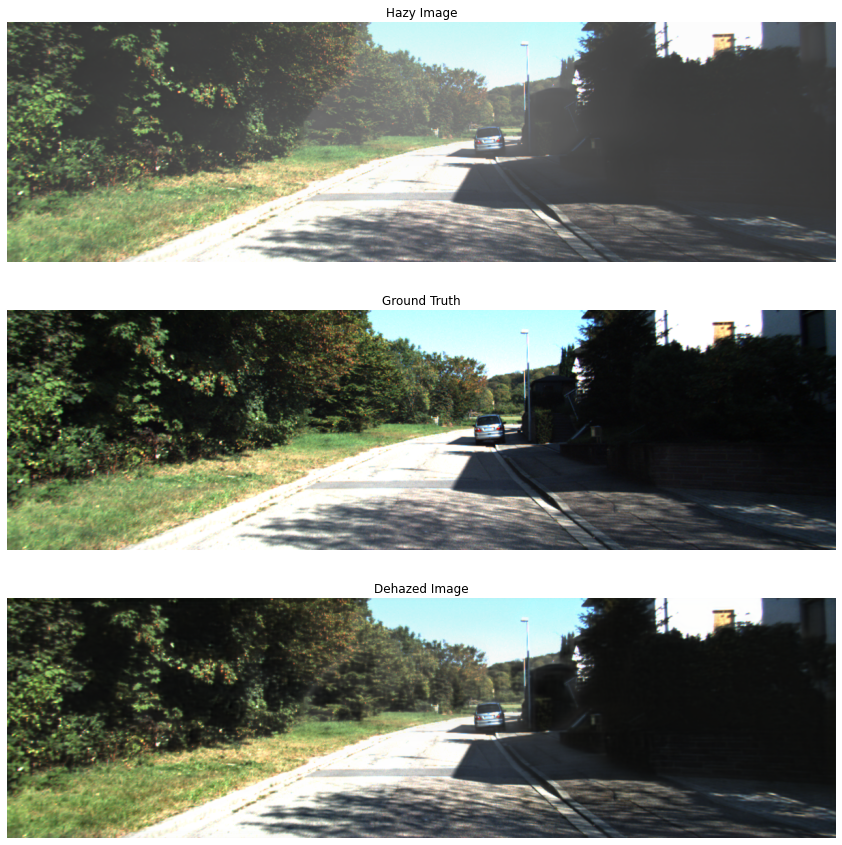

  -  Validation Loss: 0.0033  -   Time taken: 1352.72s

Start of epoch 1 [======]  -  Training Loss: 0.0036

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


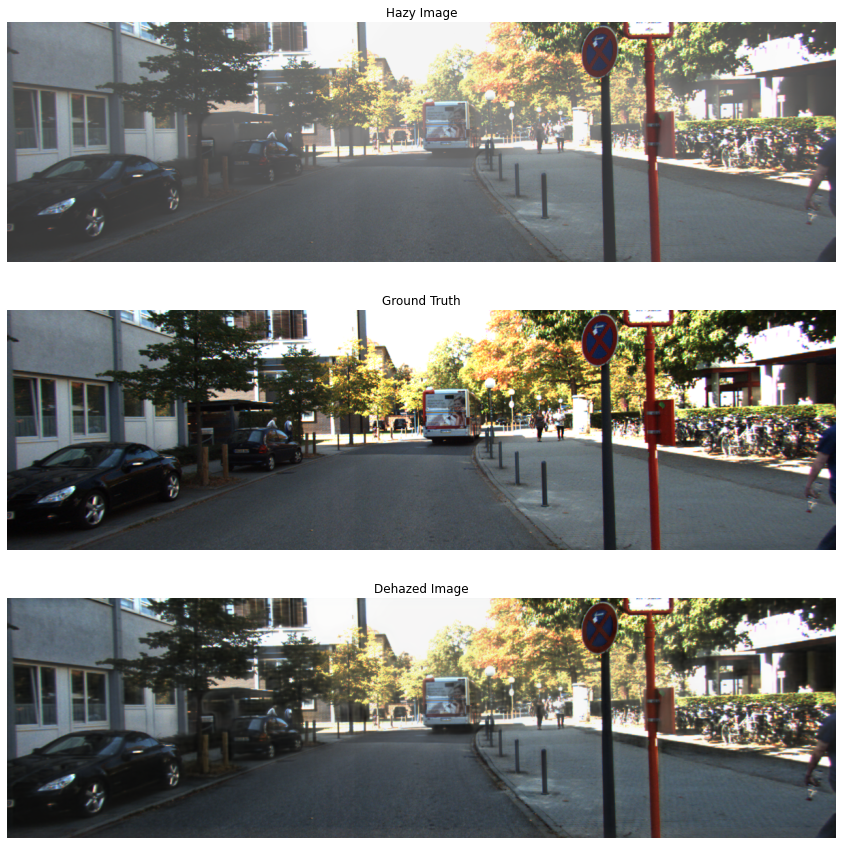

  -  Validation Loss: 0.0032  -   Time taken: 1091.98s

Start of epoch 2 [======]  -  Training Loss: 0.0035

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


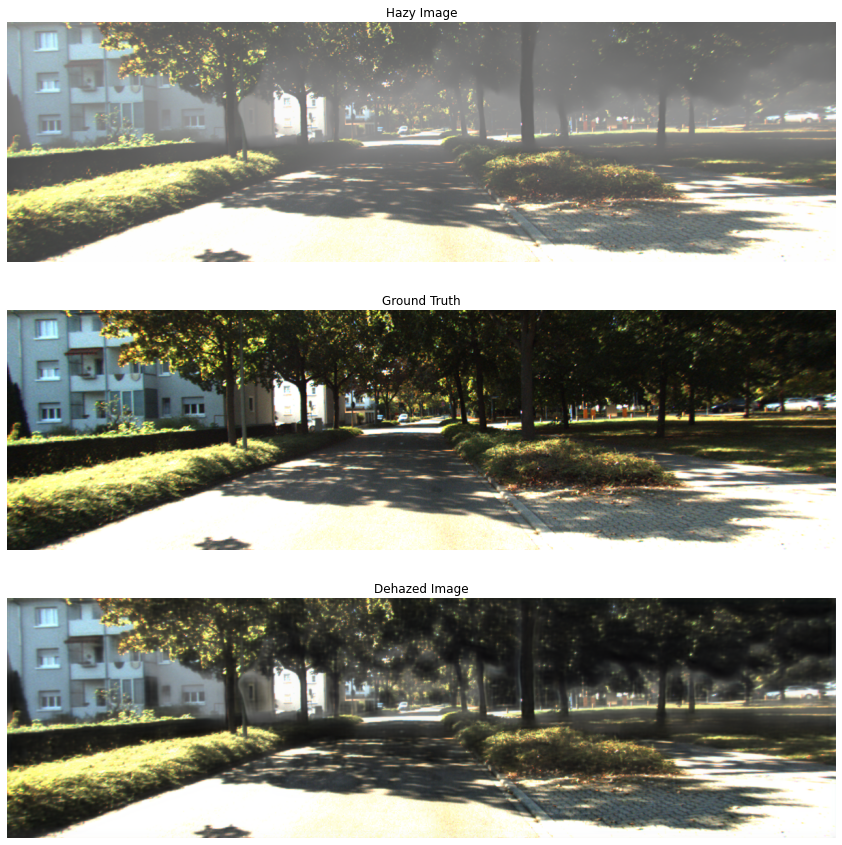

  -  Validation Loss: 0.0032  -   Time taken: 1091.40s

Start of epoch 3 [======]  -  Training Loss: 0.0035

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


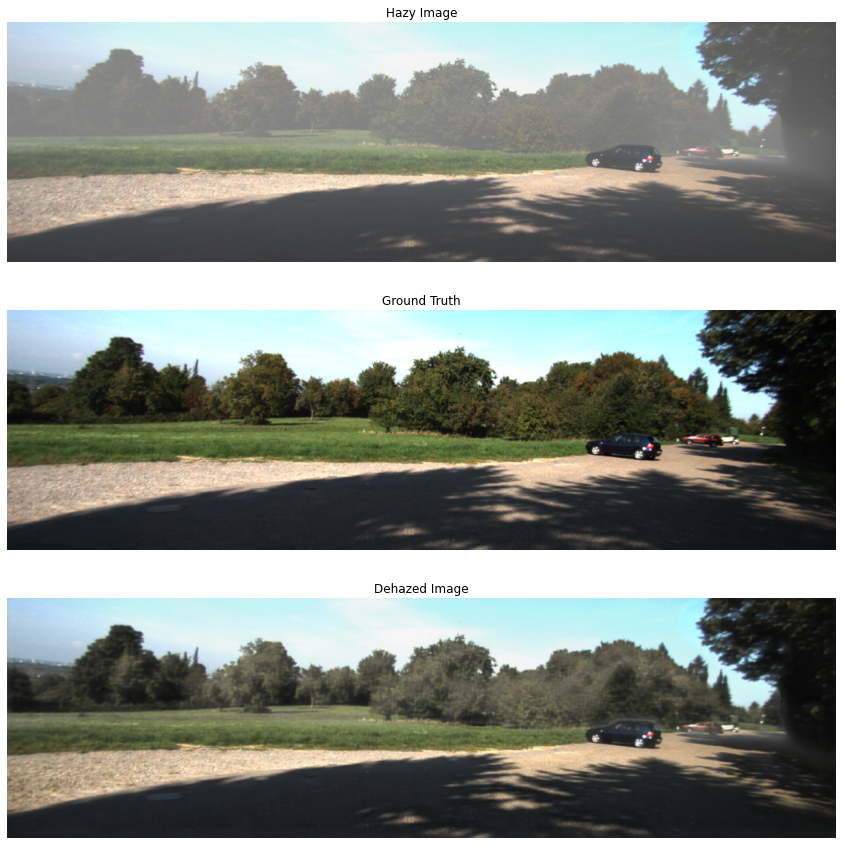

  -  Validation Loss: 0.0031  -   Time taken: 1096.76s

Start of epoch 4 [======]  -  Training Loss: 0.0034

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


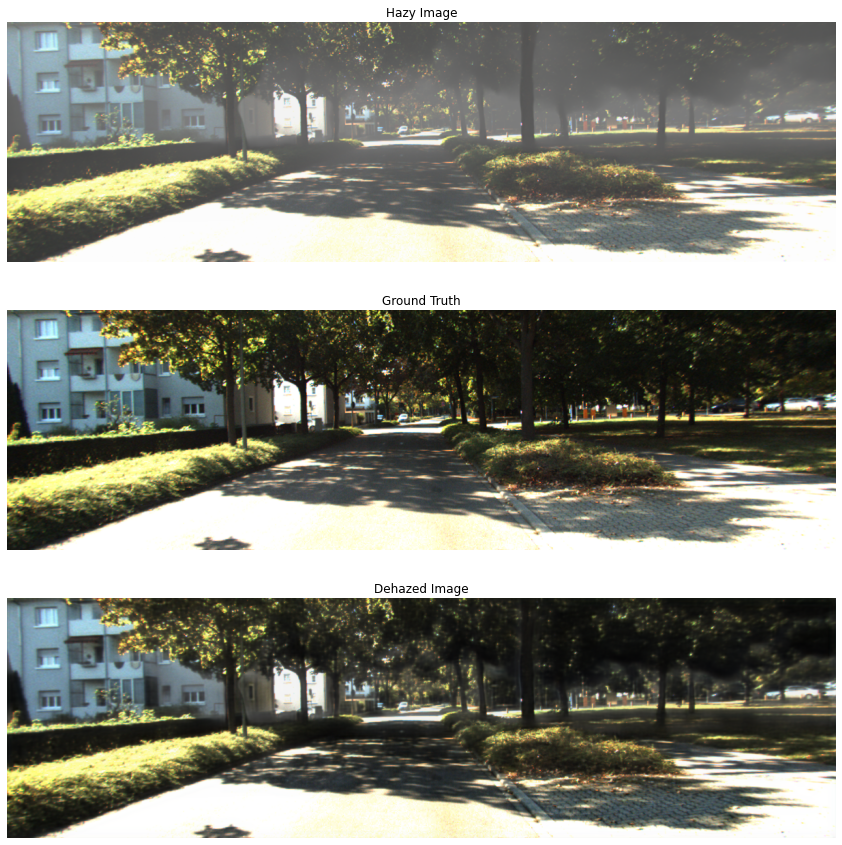

  -  Validation Loss: 0.0032  -   Time taken: 1092.65s
CPU times: user 1h 4min 14s, sys: 6min 18s, total: 1h 10min 32s
Wall time: 1h 35min 25s


In [ ]:
%%time
train_model(5, train, val,model, train_loss_tracker, val_loss_tracker, optimizer)

In [ ]:
model.save('/content/drive/MyDrive/kitti_nets/gman')

model.save_weights('/content/drive/MyDrive/kitti_nets/gman')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/kitti_nets/gman/assets


In [ ]:
##model1=tf.keras.models.load_model('/content/drive/MyDrive/aa/gman/')

In [ ]:
##model.load_weights('/content/drive/MyDrive/kitti_nets/gman')

## evaluate

In [ ]:
import cv2
import matplotlib.pyplot as plt

def evaluate_gen(net):
    
    #test_img = glob.glob(test_img_path +'/*.jpg')
    test_img=glob.glob('/content/drive/MyDrive/test_set/hazy/*.png')
    #random.shuffle(test_img)
    i=0;
    for img in test_img:
        
        img = tf.io.read_file(img)
        img = tf.io.decode_png(img, channels = 3)
        
        img = tf.image.resize(img, size = (352,1216), antialias = True)
        
        img = img / 255.0
        print(i,end=" ")
        img = tf.expand_dims(img, axis = 0)      #transform input image from 3D to 4D ###
        
        dehaze = net(img)
        
        #plt.figure(figsize = (80, 80))
        
        #display_list = [img[0], dehaze[0]]       #make the first dimension zero
        im=dehaze[0]
        #im=((dehaze[0]-0.4)/0.2)*255
        #print(im.numpy().min())
        directory = '/content/drive/MyDrive/test_set/gman/'
        os.chdir(directory)
        filename = str(i) + '_outdoor_gen.png'
        #print(filename)
        #cv2.imwrite(filename,im) 
        #plt.imsave(filename,im)
        tf.keras.preprocessing.image.save_img(
    filename, im)

        os.chdir('/content')
        i+=1;
        

In [ ]:
evaluate_gen(model)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 